## Аналитика в Яндекс.Афише.
Необходимо помочь маркетологам оптимизировать маркетинговые затраты на основе данных по посещениям сайта, покупкам и маркетинговым тратам с июня 2017 по конец мая 2018 года.

### План анализа.
1. [Импорт данных и подготовка к анализу](#1)

2. [Пользовательские метрики](#2)
  - [Пользовательской активность](#3)
  - [Метрики сессий](#4)
  - [Retention Rate](#5)
  - [Churn Rate](#6)
  
  
3. [Метрики продаж](#7)
  - [Время до первой покупки](#8)
  - [Продаж за перод](#9)
  - [Средний чек](#10)
  - [LTV](#11)


4. [Маркетинг](#12)
  - [Общие расходы](#13)
  - [Customer Acquisition Cost](#14)
  - [ROMI](#15)


5. [Вывод и рекомендации](#16)

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


matplotlib.rcParams['figure.figsize'] = [10, 10]

## Импорт данных и подготовка к анализу
<a id='1'></a>

In [2]:
# импорт датасетов
df_visits = pd.read_csv('/datasets/visits_log.csv')
df_orders = pd.read_csv('/datasets/orders_log.csv')
df_costs = pd.read_csv('/datasets/costs.csv')

In [3]:
# создаём функцию для EDA
def df_eda(df):
    print('\033[1m' + '\nШапка таблицы' + '\033[0m')
    display(df.head())
    print('\033[1m'+'\nИнформаци по колонкам\n' + '\033[0m')
    print(df.info())

In [4]:
df_visits.pipe(df_eda)


Шапка таблицы


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168



Информаци по колонкам

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


In [5]:
# переименуем колонки и приведём данные с датами в DateTime формат

df_visits.columns = ['device', 'session_end_ts', 'source_id', 'session_start_ts', 'uid']

df_visits['session_end_ts'] = pd.to_datetime(df_visits['session_end_ts'], format='%Y-%m-%d %H:%M:%S')
df_visits['session_start_ts'] = pd.to_datetime(df_visits['session_start_ts'], format='%Y-%m-%d %H:%M:%S')

df_visits['date'] = df_visits['session_start_ts'].astype('datetime64[D]')
df_visits['week'] = pd.to_datetime(df_visits['session_start_ts'], unit='d') - pd.to_timedelta(df_visits['session_start_ts'].dt.dayofweek, unit='d')
df_visits['week'] = df_visits['week'].astype('datetime64[D]')
df_visits['month'] = df_visits['session_start_ts'].astype('datetime64[M]')
df_visits.head()

,device,session_end_ts,source_id,session_start_ts,uid,date,week,month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-14,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-25,2017-12-01


In [6]:
df_orders.pipe(df_eda)


Шапка таблицы


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450



Информаци по колонкам

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None


In [7]:
# переименуем колонки и приведём данные с датами в DateTime формат

df_orders.columns = ['order_date', 'revenue', 'uid']
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'], format='%Y-%m-%d %H:%M:%S')

df_orders['date'] = df_orders['order_date'].astype('datetime64[D]')
df_orders['week'] = pd.to_datetime(df_orders['order_date'], unit='d') - pd.to_timedelta(df_orders['order_date'].dt.dayofweek, unit='d')
df_orders['week'] = df_orders['week'].astype('datetime64[D]')
df_orders['month'] = df_orders['order_date'].astype('datetime64[M]')
df_orders.head()


,order_date,revenue,uid,date,week,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-05-29,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-05-29,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-05-29,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-05-29,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-05-29,2017-06-01


In [8]:
df_costs.pipe(df_eda)


Шапка таблицы


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08



Информаци по колонкам

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


In [9]:
# переименуем колонки и приведём данные с датами в DateTime формат

df_costs['dt'] = pd.to_datetime(df_costs['dt'], format='%Y-%m-%d')

df_costs['date'] = df_costs['dt'].astype('datetime64[D]')
df_costs['week'] = pd.to_datetime(df_costs['dt'], unit='d') - pd.to_timedelta(df_costs['dt'].dt.dayofweek, unit='d')
df_costs['week'] = df_costs['week'].astype('datetime64[D]')
df_costs['month'] = df_costs['dt'].astype('datetime64[M]')

df_costs.head()

,source_id,dt,costs,date,week,month
0,1,2017-06-01,75.20,2017-06-01,2017-05-29,2017-06-01
1,1,2017-06-02,62.25,2017-06-02,2017-05-29,2017-06-01
2,1,2017-06-03,36.53,2017-06-03,2017-05-29,2017-06-01
3,1,2017-06-04,55.00,2017-06-04,2017-05-29,2017-06-01
4,1,2017-06-05,57.08,2017-06-05,2017-06-05,2017-06-01


## Считаем пользовательские метрики.
<a id='2'></a>

### 1. Метрики пользовательской активности.
<a id='3'></a>

In [10]:
print( 'Период данных по визитам:', df_visits['session_start_ts'].min(), "-", df_visits['session_start_ts'].max())

Период данных по визитам: 2017-06-01 00:01:00 - 2018-05-31 23:59:00


In [11]:
# Считаем суммарные DAU, WAU и MAU по всем данным

dau_total = df_visits.groupby(['date']).agg({'uid': 'nunique'}).mean()
wau_total = df_visits.groupby(['week']).agg({'uid': 'nunique'}).mean()
mau_total = df_visits.groupby(['month']).agg({'uid': 'nunique'}).mean()

print('DAU =', int(dau_total[0]))
print('WAU =', int(wau_total[0]))
print('MAU =', int(mau_total[0]))
print('Sticky factor WAU = {:.1%}'.format(dau_total[0] / wau_total[0]))
print('Sticky factor MAU = {:.1%}'.format(dau_total[0] / mau_total[0]))

DAU = 907
WAU = 5716
MAU = 23228
Sticky factor WAU = 15.9%
Sticky factor MAU = 3.9%


**Вывод:**

Общий показатель Sticky factor говорит о недостаточной вовлечённости пользователей. Среди активных пользователей за неделю только 15,6% пользовались сервисом ежедневно. Среди ежемесячно активных этот показатель равен 3,9%. Детализируем показатель и рассмотрим его в разрезе устройств.

In [12]:
# считаем DAU, WAU и MAU в разрезе устройств

dau_by_device = df_visits.pivot_table(index='date',
                                  columns='device',
                                  values='uid',
                                  aggfunc='nunique'
                                  )
print('DAU desktop =', int(dau_by_device['desktop'].mean()))
print('DAU touh =', int(dau_by_device['touch'].mean()))

wau_by_device = df_visits.pivot_table(index='week',
                                  columns='device',
                                  values='uid',
                                  aggfunc='nunique'
                                  )
print('WAU desktop =', int(wau_by_device['desktop'].mean()))
print('WAU touh =', int(wau_by_device['touch'].mean()))

mau_by_device = df_visits.pivot_table(index='month',
                                  columns='device',
                                  values='uid',
                                  aggfunc='nunique'
                                  )
print('MAU desktop =', int(mau_by_device['desktop'].mean()))
print('MAU touh =', int(mau_by_device['touch'].mean()))
print('-----------------------------------------')
print('Sticky factor WAU desktop = {:.1%}'.format(dau_by_device['desktop'].mean() / wau_by_device['desktop'].mean()))
print('Sticky factor WAU touch = {:.1%}'.format(dau_by_device['touch'].mean() / wau_by_device['touch'].mean()))
print('Sticky factor MAU desktop = {:.1%}'.format(dau_by_device['desktop'].mean() / mau_by_device['desktop'].mean()))
print('Sticky factor MAU touch = {:.1%}'.format(dau_by_device['touch'].mean() / mau_by_device['touch'].mean()))

DAU desktop = 659
DAU touh = 252
WAU desktop = 4129
WAU touh = 1634
MAU desktop = 16724
MAU touh = 6825
-----------------------------------------
Sticky factor WAU desktop = 16.0%
Sticky factor WAU touch = 15.5%
Sticky factor MAU desktop = 3.9%
Sticky factor MAU touch = 3.7%


Метрики пользовательской активности в разрезе устройств почти повторяют суммарные данные. Видно, что пользователи Desktop более активны и составляют около 70% от суммарных метрик. Другие 30% приходятся на пользователей Touch устройств. Также стоит отметить, что Sticky factor пользователей Desktop чуть выше, чем у пользователей Touch. Но эта разница незначительная. 

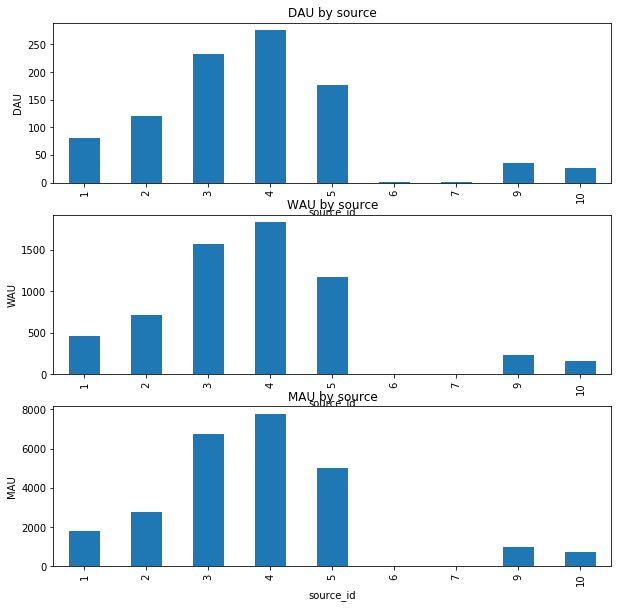

In [13]:
# посчитаем метрики активности по источникам. Построим графики для каждой метрики.

fig, axes = plt.subplots(nrows = 3, ncols = 1 )
axes[0].set(title = 'DAU by source',
           ylabel = 'DAU')
axes[1].set(title = 'WAU by source',
           ylabel = 'WAU')
axes[2].set(title = 'MAU by source',
           ylabel = 'MAU')

dau_by_source = df_visits.groupby(['date', 'source_id'])['uid'].nunique().reset_index()
dau_by_source.groupby('source_id')['uid'].mean().plot(kind='bar', ax=axes[0])

wau_by_source = df_visits.groupby(['week','source_id'])['uid'].nunique().reset_index()
wau_by_source.groupby('source_id')['uid'].mean().plot(kind='bar', ax=axes[1])

mau_by_source = df_visits.groupby(['month', 'source_id'])['uid'].nunique().reset_index()
mau_by_source.groupby('source_id')['uid'].mean().plot(kind='bar', ax=axes[2])


plt.show()

Среди источников привлечения выделяются 3 лидера: источник 4, 3 и 5. В них пользовательская активность самая высокая. Также чётко видны "мёртвые" источники 6 и 7. В них почти нет пользователей.

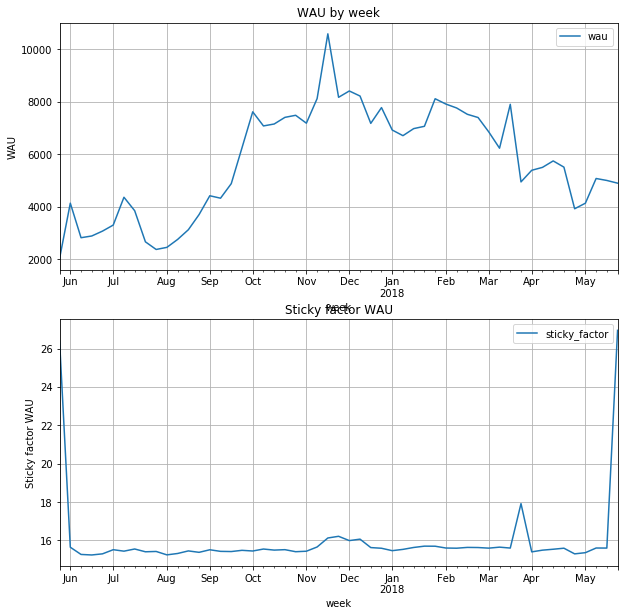

In [14]:
# Посмотрим, как менялись метрики активности со временем (по неделям и месяцам)

dau_by_week = df_visits.groupby(['week', 'date']).agg({'uid':'nunique'}).reset_index()
dau_by_week.rename({'uid':'dau'}, axis=1, inplace=True)

wau_by_week = df_visits.groupby(['week']).agg({'uid':'nunique'}).reset_index()
wau_by_week.rename({'uid':'wau'}, axis=1, inplace=True)

df_wau_by_week = (dau_by_week
    .groupby('week').agg({'dau':'mean'})
    .reset_index()
    .merge(wau_by_week, on='week')
    )
df_wau_by_week['sticky_factor'] = df_wau_by_week['dau'] / df_wau_by_week['wau'] * 100
df_wau_by_week

fig, axes = plt.subplots(nrows = 2, ncols = 1)
axes[0].set(ylabel = 'WAU')
axes[1].set(ylabel = 'Sticky factor WAU')

df_wau_by_week.plot(x='week', y='wau', grid=True, ax=axes[0], title='WAU by week')
df_wau_by_week.plot(x='week', y='sticky_factor', ax=axes[1], grid=True, title='Sticky factor WAU')
plt.show()

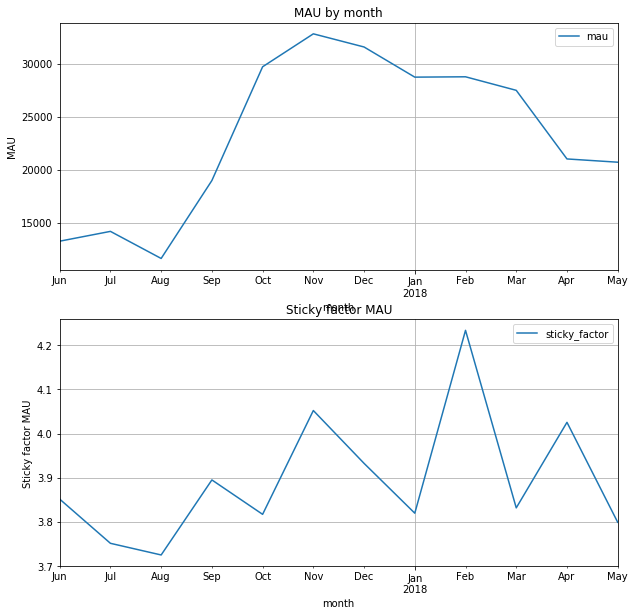

In [15]:
dau_by_month = df_visits.groupby(['month', 'date']).agg({'uid':'nunique'}).reset_index()
dau_by_month.rename({'uid':'dau'}, axis=1, inplace=True)

mau_by_month = df_visits.groupby('month').agg({'uid':'nunique'}).reset_index()
mau_by_month.rename({'uid':'mau'}, axis=1, inplace=True)

df_mau_by_month = (dau_by_month
    .groupby('month').agg({'dau':'mean'})
    .reset_index()
    .merge(mau_by_month, on='month')
    )
df_mau_by_month['sticky_factor'] = df_mau_by_month['dau'] / df_mau_by_month['mau'] * 100

fig, axes = plt.subplots(nrows = 2, ncols = 1)
axes[0].set(ylabel = 'MAU')
axes[1].set(ylabel = 'Sticky factor MAU')

df_mau_by_month.plot(x='month', y='mau', grid=True, ax=axes[0], title='MAU by month')
df_mau_by_month.plot(x='month', y='sticky_factor', ax=axes[1], grid=True, title='Sticky factor MAU')
plt.show()

Если смотреть на метрики активности во времени, видно, что самая низкая пользовательская активность приходится на начало периода (первые 3 месяца: июнь, июль, август 2017 г.). Дальше активность сильно растёт и достигает пика ровно к середине периода (ноябрь 2017). После пика идёт плавный спад активности. DAU почти достигает показателей начала перода. MAU, хоть и снижается, остаётся выше, чем в начале.

### 2. Метрики сессий.
<a id='4'></a>

**а) Количество сессий в день суммарно и по устройствам**

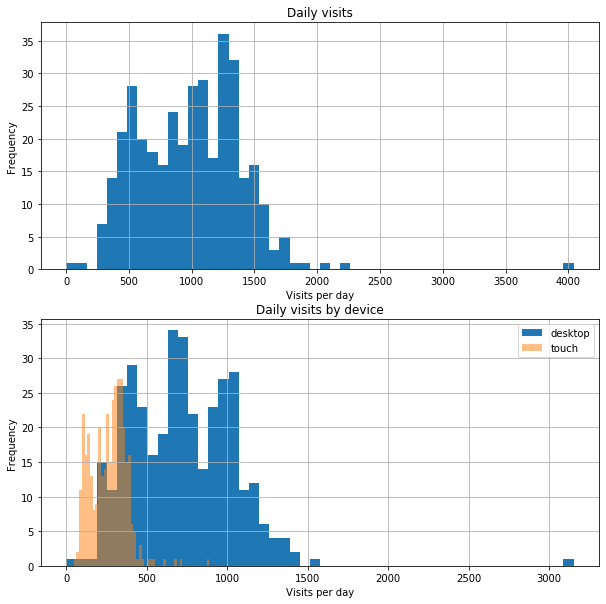

В среднем в день 987 сессий.
В среднем в день по Desktop 721 сессия.
В среднем в день по Touch 267 сессий.


In [18]:
# считаем количество визитов в день по всему периоду
daily_visits = df_visits.groupby(['date', 'month'])['uid'].agg(['count', 'nunique']).reset_index()
daily_visits.columns = ['date', 'month', 'visits', 'users']

# считаем количество визитов в день по устройствам
daily_visits_by_device = df_visits.groupby(['device', 'date'])['uid'].agg(['count', 'nunique']).reset_index()
daily_visits_by_device.columns = ['device', 'date', 'visits', 'users']

# сторим гистограммы частот
fig, axes = plt.subplots(nrows = 2, ncols = 1)
axes[0].set(xlabel = 'Visits per day',
            ylabel = 'Frequency',
            title = 'Daily visits')
axes[1].set(xlabel = 'Visits per day',
            ylabel = 'Frequency',
            title = 'Daily visits by device')


daily_visits['visits'].hist(ax=axes[0], bins=50)

daily_visits_by_device.query('device == "desktop"')['visits'].hist(bins=50, ax=axes[1], label='desktop')
daily_visits_by_device.query('device == "touch"')['visits'].hist(bins=50, ax=axes[1],alpha=0.5, label='touch')
plt.legend()
plt.show()

# выводим среднее
print('В среднем в день {:.0f}'.format(daily_visits['visits'].mean()), 'сессий.')
print('В среднем в день по Desktop {:.0f}'.format(daily_visits_by_device.query('device == "desktop"')['visits'].mean()), 'сессия.')
print('В среднем в день по Touch {:.0f}'.format(daily_visits_by_device.query('device == "touch"')['visits'].mean()), 'сессий.')

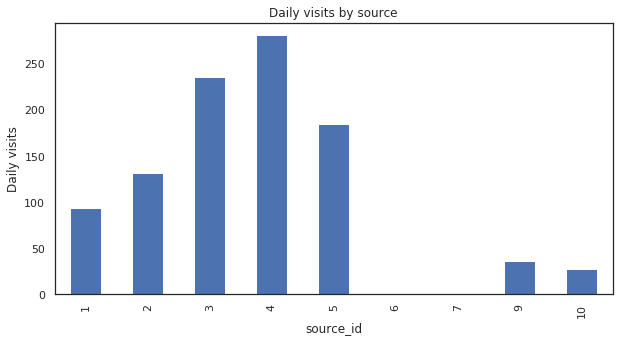

In [109]:
# посмотрим на количество сессий в день в разрезе источников

daily_visits_by_source = df_visits.groupby(['date', 'source_id'])['uid'].count().reset_index()

fig, ax = plt.subplots()
ax.set(title = 'Daily visits by source',
      ylabel = 'Daily visits')
(daily_visits_by_source
     .groupby('source_id')['uid'].mean()
     .plot(kind='bar', figsize=(10,5), ax=ax)
)
plt.show()

Среднее количество сессий в день почти совпадает с DAU. Это говорит о том, что 1 пользователь в день совершает в среднем 1 сессию. Здесь также видно, что больше 70% сессий выполняются с Desktop устройств, остальные 30% - Touch.

В разрезе источников этот показатель также почти повторяет DAU. В топ-3 вошли те же источники (4, 3, 5).

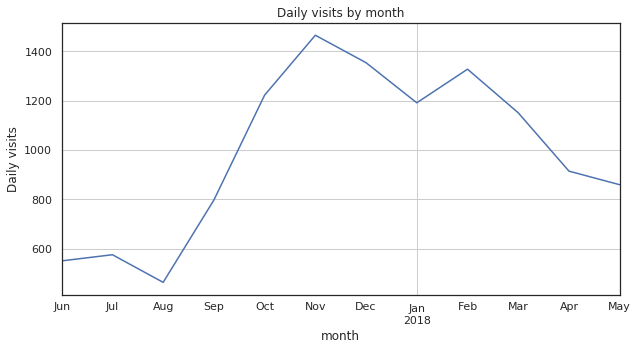

In [110]:
# Посмотрим на показатель сессий в день по месяцам

fig, ax = plt.subplots()
ax.set(ylabel = 'Daily visits') 

(daily_visits
     .groupby('month')['visits'].mean()
     .plot(grid=True, ax=ax, figsize=(10,5), title='Daily visits by month')
)
plt.show()

Средний показатель дневных сессий по месяцам имеет те же тенденции:
- наименьший показатель в начале периода
- пик в ноябре
- постепенное снижение к концу периода

**б) Сессий в день на 1 пользователя.**

В среднем 1 пользователь совершает в день 1.08 визита


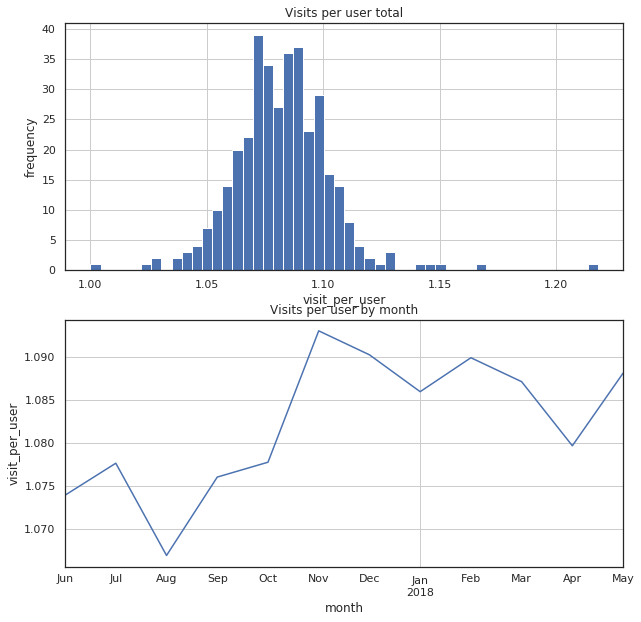

In [111]:
daily_visits['visit_per_user'] = daily_visits['visits'] / daily_visits['users']

print('В среднем 1 пользователь совершает в день',daily_visits['visit_per_user'].mean().round(2), 'визита')

fig, axes = plt.subplots(nrows = 2, ncols = 1)
axes[0].set(ylabel = 'frequency', 
            xlabel = 'visit_per_user', 
            title='Visits per user total'
           ) 
axes[1].set(ylabel = 'visit_per_user', 
            xlabel = 'month'
           ) 
 
daily_visits['visit_per_user'].hist(ax=axes[0], bins=50, grid=True)
 
(daily_visits
     .groupby(['month'])['visit_per_user'].mean()
     .plot(grid=True, ax=axes[1], title='Visits per user by month')
)
plt.show()

В среднем на 1 уникального пользователя за день приходится 1 визит на сайт. Распределение похоже на нормальное. По месяцам картина напоминает предыдущие метрики:
- в начале периода значение сессий на 1 пользователя минимально и к августу достигает "дна" (меньше 1,07) 
- после этого идёт быстрый подъём с пиком в ноябре (больше 1,9 сессии на пользователя)
- далее небольшой спад до среднего показателя в 1,08 и снова рост на последнем месяце.

**в) Длительность сессии. ASL.**

Средняя продолжительность сессии: 643 сек
Медиана длительности сессии: 300 сек
Мода длительности сессии: 60 сек


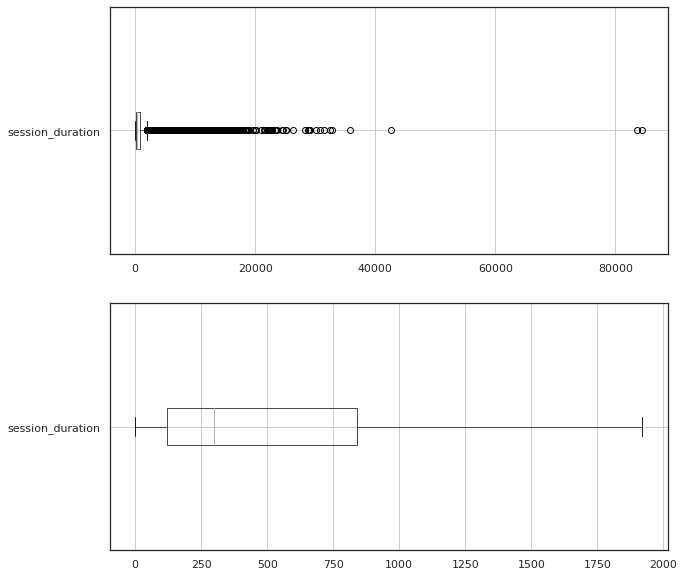

In [112]:
df_visits['session_duration'] = (df_visits['session_end_ts'] - df_visits['session_start_ts']).dt.seconds

fig, axes = plt.subplots(nrows = 2, ncols = 1)
df_visits.boxplot('session_duration', vert=False, ax=axes[0])
df_visits.boxplot('session_duration', vert=False, showfliers=False, ax=axes[1])

print('Средняя продолжительность сессии:', int(df_visits['session_duration'].mean()), 'сек')
print('Медиана длительности сессии:', int(df_visits['session_duration'].median()), 'сек')
print('Мода длительности сессии:', df_visits['session_duration'].mode()[0], 'сек')

Данные по длительности сессий имеют тяжёлый хвост выбросов. Медиана сильно смещена влево на графике boxplot и равна 300 секундам. Можно сказать, что средняя сессия длится 5 минут, а 75% сессий длятся менее 15 минут.

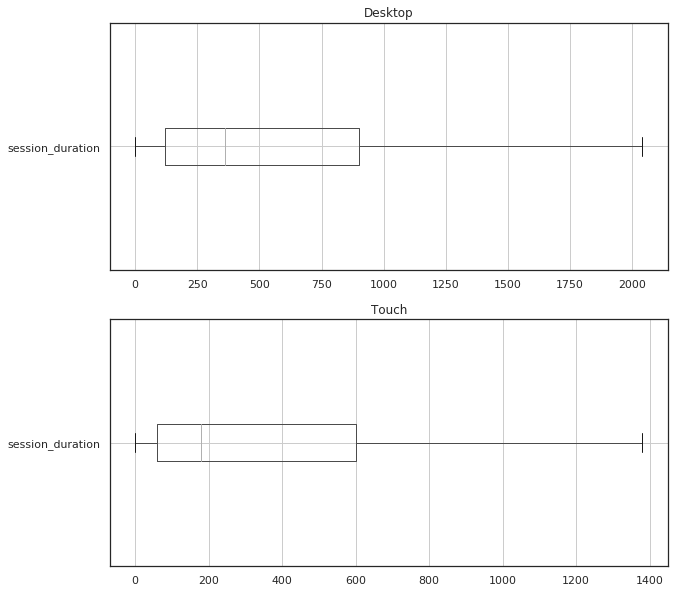

Медиана длительности сессии по Desktop: 360 сек
Медиана длительности сессии по Touch: 180 сек


In [113]:
# Посмотрим на длительность сессии в разрезе устройств

fig, axes = plt.subplots(nrows = 2, ncols = 1)

axes[0].set(title='Desktop')
axes[1].set(title='Touch')
df_visits.query('device == "desktop"').boxplot('session_duration', vert=False, showfliers=False, ax=axes[0])
df_visits.query('device == "touch"').boxplot('session_duration', vert=False, showfliers=False, ax=axes[1])
plt.show()

print('Медиана длительности сессии по Desktop:', int(df_visits.query('device == "desktop"')['session_duration'].median()), 'сек')
print('Медиана длительности сессии по Touch:', int(df_visits.query('device == "touch"')['session_duration'].median()), 'сек')

Медианное значение длительности сессии из Desktop устройств в два раза больше, чем в Touch. В среднем сессия с Desktop длится 6 минут, с Touch - 3 минуты.

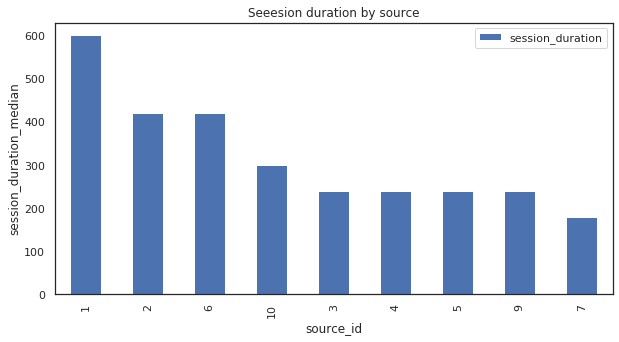

In [114]:
fig, ax = plt.subplots()
ax.set(ylabel = 'session_duration_median', xlabel = 'source_id')

(df_visits
 .groupby('source_id')['session_duration'].median()
 .reset_index()
 .sort_values(by='session_duration', ascending=False)
 .plot(kind='bar', x='source_id', y='session_duration', figsize=(10,5), ax=ax, title='Seeesion duration by source')
)
plt.show()

В разрезе источников всех дольше сессия длится из источника 1, почти 10 минут. Следом идут источники 2 и 6 с продолжительностью средней сессии в 6,5 минут и источник 6 - 5 минут. Источники 4,5 и 9 имеют среднюю продолжительность сессии около 4,5 минут.

Интересно, что топ-3 источников по пользовательской активности (4, 3 и 5) имеют одну из самых коротких длительностей сессий.

### Retention Rate.
<a id='5'></a>

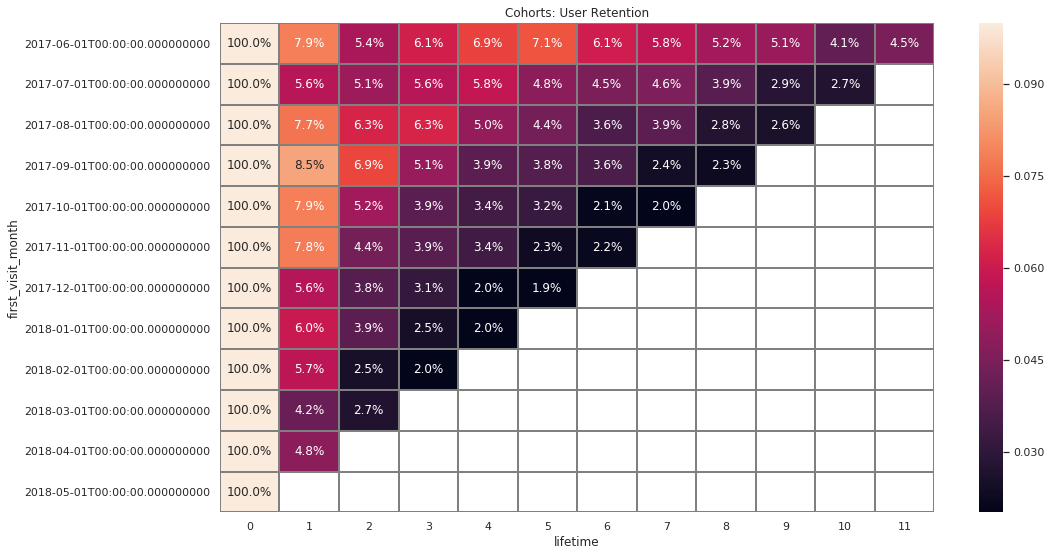

In [115]:
# найдём дату первого визита по каждому пользователю и добавим эти данные в датасет
first_visit_month = df_visits.groupby('uid')['month'].min()
first_visit_month.name = 'first_visit_month'
df_visits = df_visits.merge(first_visit_month, on='uid')

# найдём lifetime для каждого визита 
df_visits['lifetime'] = (df_visits['month'] - df_visits['first_visit_month']) / np.timedelta64(1,'M')
df_visits['lifetime'] = df_visits['lifetime'].round().astype('int')

# сторим когорты
cohorts_visits = df_visits.groupby(['first_visit_month','lifetime']).agg({'uid':'nunique'}).reset_index()

# считаем количество пользоателей в каждой когорте и добавляем эти данные в датасет с когортами
cohort_users_counts = cohorts_visits[cohorts_visits['lifetime'] == 0][['first_visit_month','uid']]
cohort_users_counts.rename(columns={'uid':'cohort_users'}, inplace=True)
cohorts_visits = cohorts_visits.merge(cohort_users_counts, on='first_visit_month')

# считаем retention и строим сводную таблицу
cohorts_visits['retention'] = cohorts_visits['uid'] / cohorts_visits['cohort_users']
cohorts_visits_pivot = cohorts_visits.pivot_table(index='first_visit_month',
                                                  columns='lifetime',
                                                  values='retention')

sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(cohorts_visits_pivot, annot=True, fmt='.1%', vmax=0.1, linewidths=1, linecolor='gray', robust=True);

- В среднем в следующий месяц после первого захода на сайт приходит меньше 8% пользователей;
- Заметно, что % повторно "вернувшихся" в первый месяц жизни снижается от когорты к когорте. В первых когортах этот показатель был часто выше 7,7%, после декабрьской когорты показатель не поднимался выше 6% и продолжает падать.
- Первая когорта отличается от остальных. Её всех долше удаётся удерживать % вернувшихся пользователей. На последнем месяце жизни показатель остаётся выше 4%, в то время как во всех остальных когортах он опускается ниже 3%.
- Так же выбивается диагональ с 10 lifetime для первой когорты до 0 lifetime последней когорты. До этого был плавный и небольшой отток возвращающихся пользователей. Но в этой диагонали произошёл резкий спад на 1% и больше. Не упали только первая когорта (которая и так отличается) и апрельская когорта, для которой этот месяц был первым после первого захода на сайт. На следующий месяц % возвращающихся пользователей так и не отрос и продолжил падение. Что-то произошло в апреле-мае 2018 года, что сильно повлияло на Retention.  

## Churn Rate.
<a id='6'></a>

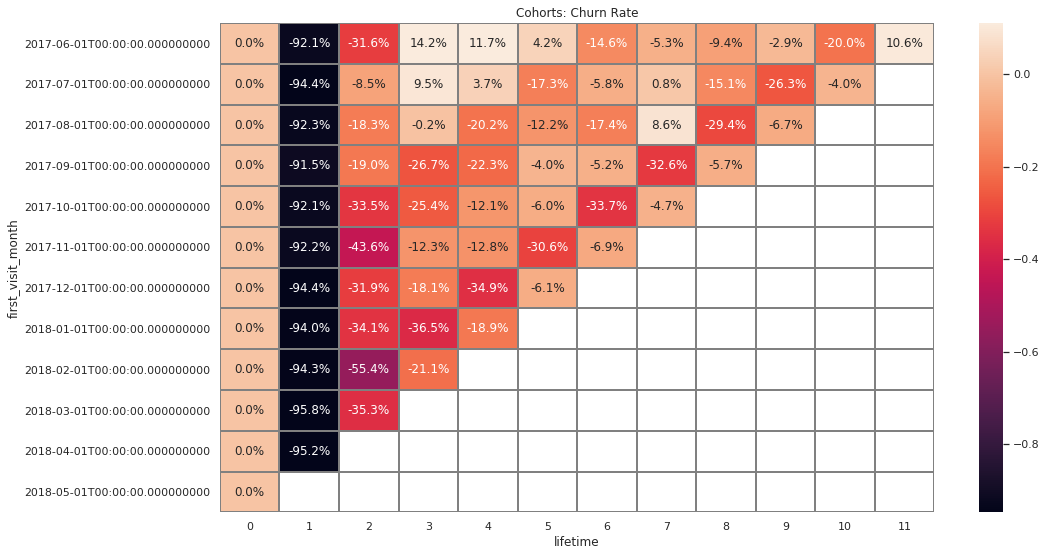

In [116]:
# # считаем churn_rate и строим сводную таблицу
cohorts_visits['churn_rate'] = cohorts_visits.groupby('first_visit_month')['uid'].pct_change()
cohorts_pivot_churn = cohorts_visits.pivot_table(index='first_visit_month',
                                         columns='lifetime',
                                         values='churn_rate',
                                         aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Cohorts: Churn Rate')
sns.heatmap(cohorts_pivot_churn, annot=True, fmt='.1%', linewidths=1, linecolor='gray', robust=True);

Хитмап по оттоку показывает те же особенности:
- На следующий месяц после первого захода на сайт мы терямт больше 90% пользователей и этот показатель растёт от когорты к когорте.
- Выдающаяся первая когорта, в которой чаще всего churn_rate положительный.
- Выделяется та же диагональ, которая соответствует апрелю - маю 2018 года. До этого в целом % оттока снижался от месяца к месяцу в каждой когорте. Но в апреле происходит резкий скачок и мы терям в среднем более 30% пользователей.

## Метрики продаж.
<a id='7'></a>

### 1. Время от появления на сайте до первой покупки.
<a id='8'></a>

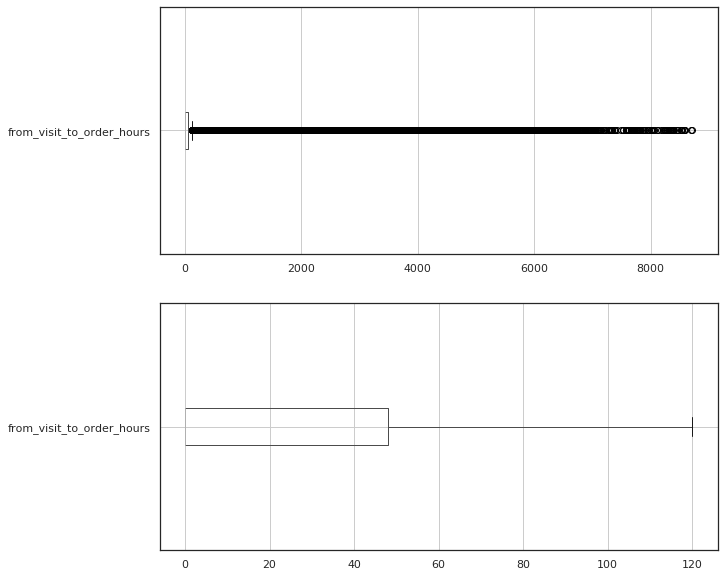

Среднее от первого визита до покупки: 405 часов
Медиана от первого визита до покупки: 0 часов
Мода от первого визита до покупки: 0 часов


In [117]:
# находим дату и время первого визита на сайт по каждому пользователю
first_visit = df_visits.groupby('uid')['session_start_ts'].min().reset_index()
first_visit.rename(columns={'session_start_ts':'first_visit'}, inplace=True)

# находим дату и время первой покупки по uid, добавляяем к этому данные о первом визите
first_order = df_orders.groupby('uid')['order_date'].min().reset_index()
first_order.rename(columns = {'order_date':'first_order'}, inplace=True)
first_order = first_order.merge(first_visit, on='uid', how='left')

# считаем разницу в часах между первым визитом и первой покупкой, стром распределение
first_order['from_visit_to_order_days'] = (first_order['first_order'] - first_order['first_visit']).dt.days
first_order['from_visit_to_order_seconds'] = (first_order['first_order'] - first_order['first_visit']).dt.seconds
first_order['from_visit_to_order_hours'] = first_order['from_visit_to_order_days']*24 + first_order['from_visit_to_order_seconds']//3600

fig, axes = plt.subplots(2,1)
first_order.boxplot('from_visit_to_order_hours', vert=False, ax=axes[0])
first_order.boxplot('from_visit_to_order_hours', vert=False, showfliers=False, ax=axes[1])
plt.show()

# смотрим на меры центральной тенденции
print('Среднее от первого визита до покупки:', int(first_order['from_visit_to_order_hours'].mean()), 'часов')
print('Медиана от первого визита до покупки:', int(first_order['from_visit_to_order_hours'].median()), 'часов')
print('Мода от первого визита до покупки:', int(first_order['from_visit_to_order_hours'].mode()[0]), 'часов')

Данные о времени между первым визитом и первой покупкой имеют большой хвост выбросов вплоть до 8000 часов (333 дня). При этом медиана упирается в 0, значит половина пользователей совершают покупку одновременно с первым визитом. 75% пользователей совершают покупку в течении 2 суток с момента первого визита, а большиснтво пользователей (правая граница нормального распределения) - в течении 5 дней.

In [118]:
# Найдём первый источник захода на сайт для каждого пользователя и добавим к данным по покупкам
first_visit_source = (df_visits
                          .sort_values(by='session_start_ts')[['uid', 'source_id']]
                          .groupby('uid')['source_id'].first()
                          .reset_index()
                     )
first_order = first_order.merge(first_visit_source, on='uid', how='left')

# Посмотрим на медиану времени по источникам
first_order.groupby('source_id')['from_visit_to_order_hours'].agg(['count', 'mean', 'median'])

,count,mean,median
source_id,,,
1,2899,248.317006,0
2,3506,495.374786,0
3,10473,421.943856,0
4,10296,395.039336,0
5,6931,334.208339,0
7,1,0.000000,0
9,1088,1071.189338,74
10,1329,286.749436,0


По источникам почти везде медиана от захода на сайт до покупки 0 часов. Выделяется только источник 9. Больше 1000 пользователей, пришедших через этот источник, в среднем потратили 3 суток до покупки.

### 2. Сколько раз покупают за период?
<a id='9'></a>

В этом пункте анализа необходимо понять, сколько 1 пользователь покупает запериод. Для анализа возьмём период 6 месяцев и только те когорты, которые прожили полные 6 месяцев.

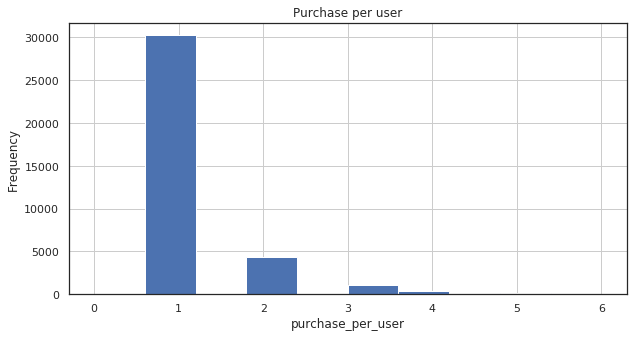

In [119]:
# найдём месяц первой покупки для каждого пользователя
first_order = df_orders.groupby('uid')['month'].min()
first_order.name = 'first_order_month' 
df_orders = df_orders.merge(first_order, on='uid')

# добавим данные по lifetime
df_orders['lifetime'] = (df_orders['month'] - df_orders['first_order_month']) / np.timedelta64(1,'M')
df_orders['lifetime'] = df_orders['lifetime'].round().astype('int')

# выберём покупателей, которые прожили более 6 месяцев и возьмём данные только за 6 месяев их жизни
df_orders.query('first_order_month <= "2017-11-01" & lifetime <= 6')

# посчитаем сколько раз каждый пользователь совершал покупки
fig, ax = plt.subplots()
ax.set(ylabel = 'Frequency', xlabel = 'purchase_per_user', title='Purchase per user')

df_orders.groupby('uid')['revenue'].count().hist(range=(0, 6), figsize=(10,5))
plt.show()

Большинство пользователей (более 30000) не совершают покупок в течение полугода с момента первой покупки. Небольшая часть пользователей (чуть меньше 5000) делает одну повторную покупку. И совсем редки случаи, когда пользователь совершает 2 и более покупки за полгода с момента первой покупки.

### Средний чек.
<a id='10'></a>

Средний чек за весь период 5.0
Медианный чек за весь период 2.5


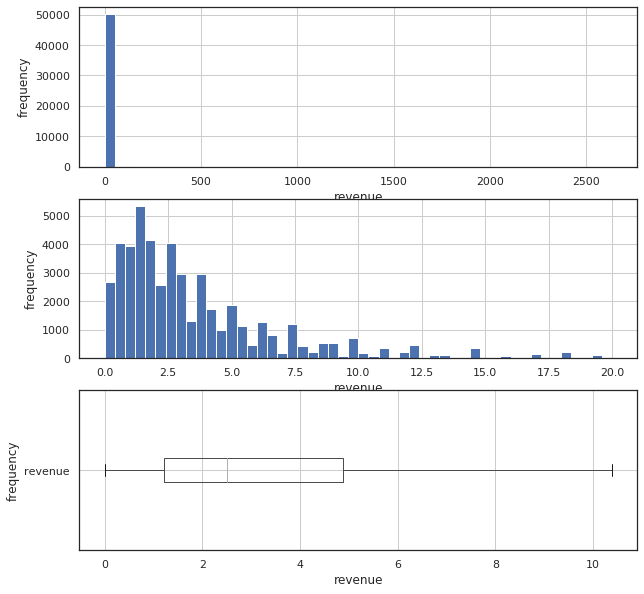

In [120]:
print('Средний чек за весь период', df_orders['revenue'].mean().round(2))
print('Медианный чек за весь период', df_orders['revenue'].median().round(2))

fig, axes = plt.subplots(nrows = 3, ncols =1 )

for ax in axes.flat:
    ax.set(xlabel='revenue',
        ylabel='frequency')

df_orders['revenue'].hist(bins=50, ax=axes[0])
df_orders['revenue'].hist(bins=50, range=(0,20), ax=axes[1])
df_orders.boxplot('revenue', vert=False, showfliers=False, ax=axes[2])
plt.show()

Данные по среднему чеку за весь период имеют длинный хвост, поэтому среднее (5,0) в 2 раза больше медианы (2,5). По графику boxplot также видно, что больше 75% покупок стоят чуть меньше 5.0, а большинстов покупок укладываются в чек = 11. При этом есть редкие выбросы вплоть до 20.0.

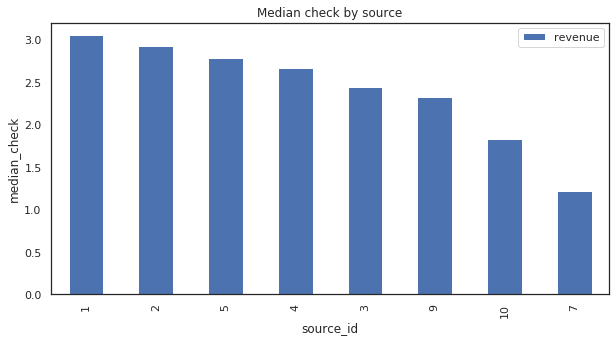

In [121]:
# Посмотрим, как на средний чек вляиют источники. 
# Добавим первый источкник входа на сайт для каждого пользователя к данным по продажам.

df_orders = df_orders.merge(first_visit_source, on='uid')

fig, ax = plt.subplots()
ax.set(ylabel = 'median_check', xlabel = 'source_id')

(df_orders
     .groupby('source_id')['revenue'].median()
     .reset_index()
     .sort_values(by='revenue', ascending=False)
     .plot(kind='bar', x='source_id', y='revenue', figsize=(10,5), ax=ax, title='Median check by source')
)
plt.show()

Сразу 4 источника (1, 2, 5, 4) имеют средний чек выше общего в 2,5. Интересно,что источник 1 имеет и самую продолжительную сессию и самый большой средний чек среди источников.

В источниках 3 и 9 средний чек близок к медиане. Источники 10 и 7 имеют самый низкий чек - ниже 2.0.

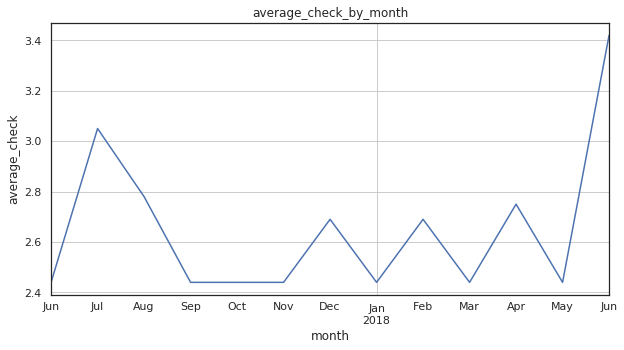

In [122]:
# посмотрим, как менялось медианное значение чека по месяцам

fig, ax = plt.subplots()
ax.set(ylabel = 'average_check')   

(df_orders
     .groupby('month')['revenue'].median()
     .plot(grid=True, figsize=(10,5), title='average_check_by_month', ax=ax)
)
plt.show()

Значение медианы средней стоимости покупки "пульсирует". Начинаясь с самого низкого значения около 2,5, медиана то отрастает, то снова опускается на первоначально значение. Интересно, что шаг между спуском и подъём почти всегда - 1 месяц.

### LTV.
<a id='11'></a>

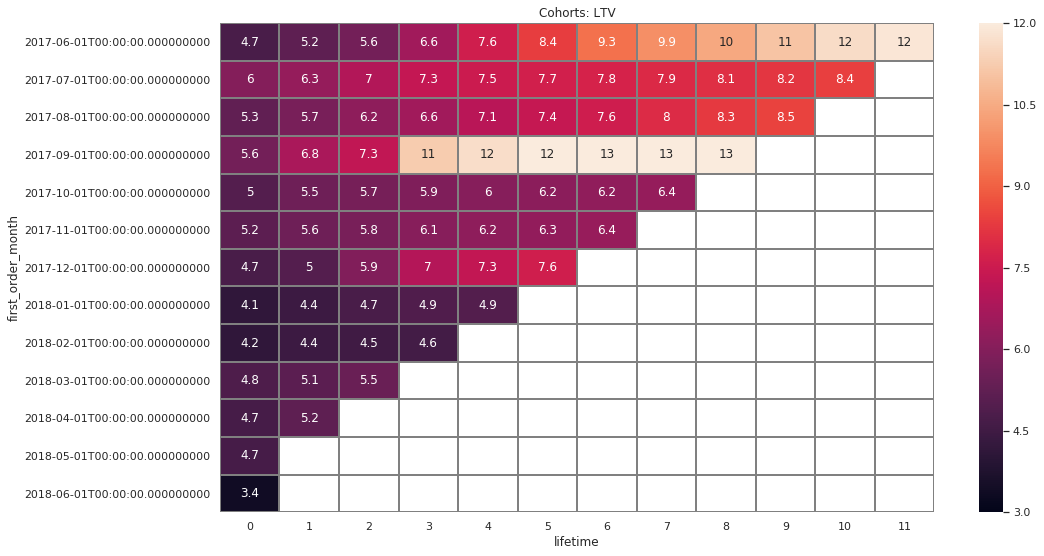

In [123]:
# считаем LTV по когортам
ltv_cohort_size = df_orders.query('lifetime == 0').groupby('first_order_month')['uid'].nunique().reset_index()
ltv_cohort_size.rename(columns={'uid':'cohort_size'}, inplace=True)

ltv_cohorts = df_orders.groupby(['first_order_month', 'lifetime']).agg({'revenue':'sum'}).reset_index()
ltv_cohorts = ltv_cohorts.merge(ltv_cohort_size, on='first_order_month')
ltv_cohorts['ltv'] = ltv_cohorts['revenue'] / ltv_cohorts['cohort_size']

ltv_cohorts_pivot = ltv_cohorts.pivot_table(index='first_order_month',
                                           columns='lifetime',
                                           values='ltv')
sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Cohorts: LTV')
sns.heatmap(ltv_cohorts_pivot.cumsum(axis=1), annot=True, vmin=3, vmax=12, linewidths=1, linecolor='gray', robust=True);

- По метрике LTV снова сильно выделяется первая когорта. Почти на каждом этапе жизни её показатель LTV выше, чем в остальных когортах. 
- Так же выделяется сентябрьская когорта. Она уже к 3 месяцу жизни догнала максимальный показатель первой когорты за весь период.
- На графике LTV совсем не видно апрельский и майских провалов в Retention. В этих диагоналях LTV продолжает расти прежними темпами.

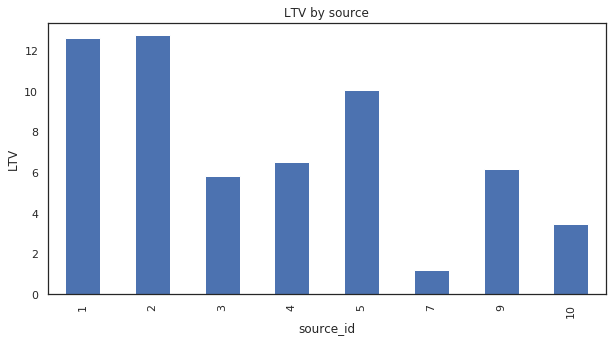

In [124]:
# посмотрим на LTV в разрезе источников. 
# Для этого также возьмём когорты, которые прожили полные 6 месяцев и посчитаем LTV за 6 месяцев жизни.

orders_six_month = df_orders.query('first_order_month <= "2017-11-01" & lifetime <= 6')
ltv_by_source = orders_six_month.groupby('source_id').agg({'uid':'nunique', 'revenue':'sum'})
ltv_by_source['ltv'] = ltv_by_source['revenue'] / ltv_by_source['uid']

fig, ax = plt.subplots()
ax.set(ylabel = 'LTV')
ltv_by_source['ltv'].plot(kind='bar', figsize=(10,5), title='LTV by source')
plt.show()

В топе источники с самым большим медианным чеком (1 и 2). За шесть месяцев жизни каждый пользователь этих источник принёс больше 12.0 дохода. На 3-м месте, и по среднему чеку и по LTV источник 5 с более чем 10.0 дохода на пользователя.

## Маркетинг.
<a id='12'></a>

### 1.Сколько потратили всего.
<a id='13'></a>

In [125]:
print('За весь период потратили', df_costs['costs'].sum())

За весь период потратили 329131.62


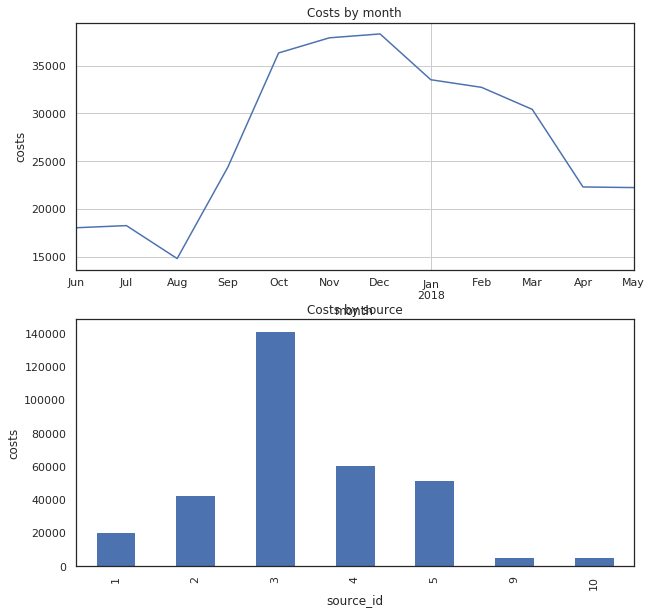

In [126]:
fig, axes = plt.subplots(nrows=2, ncols=1 )

axes[0].set(ylabel = 'costs')   
(df_costs
     .groupby('month')['costs'].sum()
     .plot(grid=True, ax=axes[0], title='Costs by month')
)

axes[1].set(ylabel = 'costs')   
(df_costs
     .groupby('source_id')['costs'].sum()
     .plot(kind='bar', ax=axes[1], title='Costs by source')
)
plt.show()

График расходов по месяцам совпадает с графиками пользовательской активности:
- низкий показатель в начале периода;
- быстрый рост к ноябрю-декабрю
- плавный спад

Среди источник самым дорогим оказался источник 3. Затраты на привлечение клиентов черех этот источник почти в 2 раза превышают остальные. При этом этот источник не самый прибыльный.
Интересно, что самые прибыльные источники по среднему чеку и LTV (1 и 2) , почти самые дешёвые с точки зрения привлечения клиентов.

## Сколько стоило привлечение одного пользователя.
<a id='14'></a>

Привлечение одного покупателя стоило в среднем 9.32


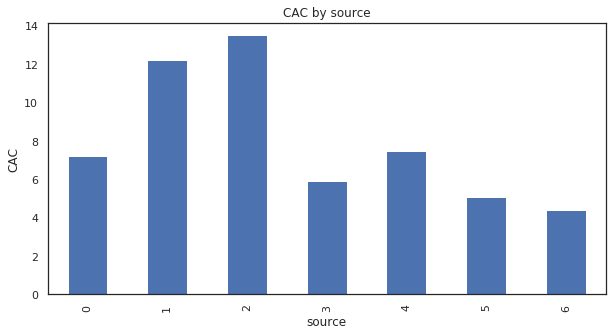

In [127]:
# посчитаем сколько было потрачено на привлечение каждой месячной когорты
# добавим эти данные к таблице с когортами по LTV
cohort_cost = df_costs.groupby('month')['costs'].sum().reset_index()
cohort_cost.rename(columns={'month':'first_order_month'}, inplace=True)
ltv_cohorts = ltv_cohorts.merge(cohort_cost, on='first_order_month')

# считаем CAC
ltv_cohorts['cac'] = ltv_cohorts['costs'] / ltv_cohorts['cohort_size']
print('Привлечение одного покупателя стоило в среднем', ltv_cohorts['cac'].mean().round(2))

# Считаем CAC по источникам
source_buyers = df_orders.groupby('source_id')['uid'].nunique().reset_index()
source_costs = df_costs.groupby('source_id')['costs'].sum().reset_index()
source_buyers = source_buyers.merge(source_costs, on='source_id')

source_buyers['cac'] = source_buyers['costs'] / source_buyers['uid']

fig, ax = plt.subplots()
ax.set(ylabel = 'CAC',
      xlabel='source')
source_buyers['cac'].plot(kind='bar', figsize=(10,5), title='CAC by source', ax=ax)
plt.show()

Самыми дорогимим пользователями оказались те, кто пришёл из источников 1 и 2. Интересно, что общая стоимость привлечения клиентов из этих истоников небольшая. Это объясняется метриками активности, которые в этих истоников низкие.

Пользователи из источников 3 и 4 обходятся в два раза дешевле, являются гораздо активнее, но приносят меньше суммарного дохода.

## ROMI.
<a id='15'></a>

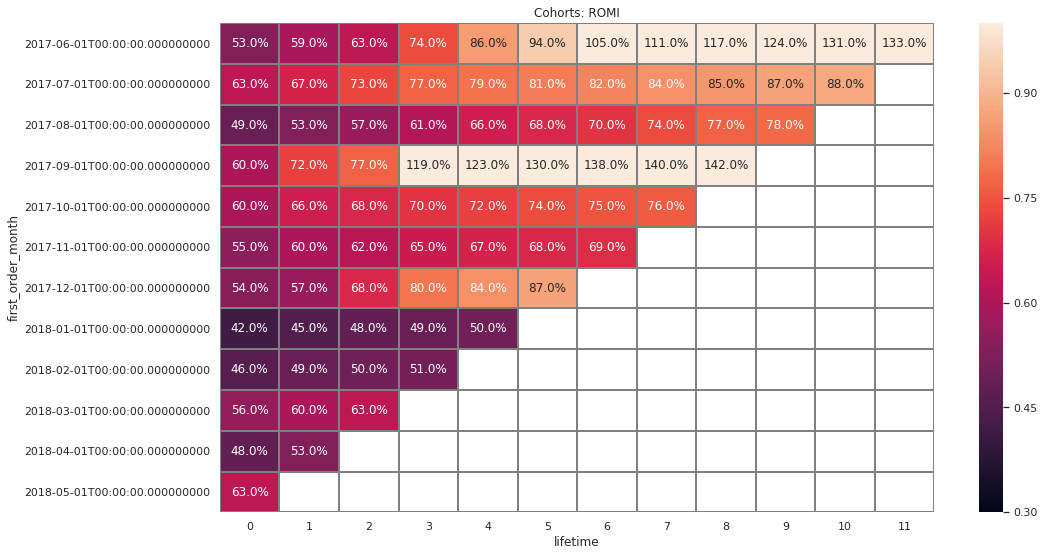

In [128]:
# считаем ROMI 
ltv_cohorts['romi'] = ltv_cohorts['ltv'] / ltv_cohorts['cac']
romi_pivot = ltv_cohorts.pivot_table(index='first_order_month', 
                                    columns='lifetime',
                                    values='romi')
sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Cohorts: ROMI')
sns.heatmap(romi_pivot.cumsum(axis=1).round(2), annot=True, fmt='.1%', vmin=0.3, vmax=1, linewidths=1, linecolor='gray', robust=True);

- Только 2 когорыт полностью окупили маркетинговые затраты.
- В среднем в первый месяц каждая когорта окупает больше 50% затрат.
- Даже если не учитывать 2 аномальные когорты, трудно вывести какие-то закономерности в остальных коготах. % ROMI сильно варьируется.

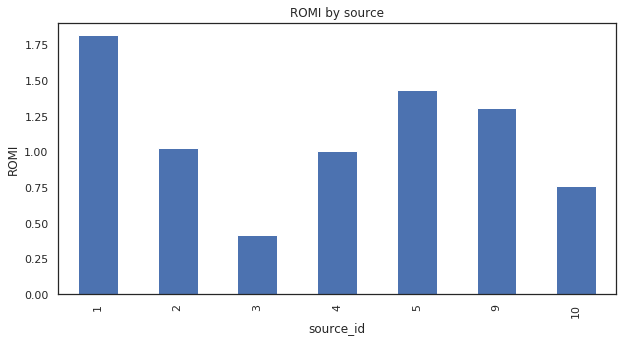

In [129]:
## для подсчёт ROMI по когортам так же возьмём период 6 месяцов для когорт, которые прожили полные 6 месяцев

six_month_cost_by_source = (df_costs
                                .query('month <= "2017-11-01"')
                                .groupby('source_id')['costs'].sum()
                           )
ltv_by_source = ltv_by_source.merge(six_month_cost_by_source, on='source_id')

ltv_by_source['cac'] = ltv_by_source['costs'] / ltv_by_source['uid']
ltv_by_source['ROMI'] = ltv_by_source['ltv'] / ltv_by_source['cac']

fig, ax = plt.subplots()
ax.set(ylabel = 'ROMI')
ltv_by_source['ROMI'].plot(kind='bar', figsize=(10,5), title='ROMI by source', ax=ax)
plt.show()

Сверх окупаются за 6 месяцев затраты на привлечение клиентов по источникам 1, 5 и 9. Клиенты из источников 2 и 4 приближаются к окупаемости в 100%. Остальные источник за 6 месяцев не окупаются за полгода.

## Выводы и рекомендации:
<a id='16'></a>

1. Стоит подробнее изучить состав, источники привлечения и поведение клиентов из июньскойи сентябрьской когорт 2017 года. Затраты на привлечение этих когорт окупились сверх быстро. Более того, это единственный когорты, которые окупили затраты. Возможно этот анализ можно будет масштабировать на дальнейшее привлечение.

2. Дополнительно изучить, что произошло в апреле-мае 2018 года. На эти месяцы приходится сильный отток пользовательской активности на сайте.

3. Touch устройства сильно уступают Desktop по показателям пользовательской активности. Возможно, стоит проверить мобильную версию сайта и внести доработки.

4. По источникам привлечение особое внимание следует уделить источнику 3. Через этот источник приходит много пользователей (2 место по пользовательской активности) и LTV источника неплохое (3 место). Но средний чек по этому источнику один из самых низких, а суммарные затраты на привлечение - самые высокие. Отсюда и самый низкий ROMI. Необходимо увеличить средний чек в этом источнике, тогда показатель ROMI улучшиться.

5. Самым выгодным оказался 1-ый источник. Средний чек, LTV и ROMI для него выше всех остальных. И ему есть, куда расти, потому что по метркам пользовательской активности этот источник всего лишь на 5-ом месте. На нём можно сделать акцент при планирование маркетинговых кампаний в дальнейшем.

6. Так же выделяется источник 5. Высокий показатель среднего чека и ROMI при низкой стоимости привлечения одного клинта. Увеличив затраты на этот источник, мы также ивеличим и прибыль компании.

7. Из данных видно, что большиснтво пользователей совершают покупку сразу же после первого захода на сайт или в течение нескольких часов. Также большинство пользователей совершают только 1 покупку в течение полугода с момента первой покупки. Этот показатель стоит улучшить, например, сделав ежмесячную рекламную рассылку по пользователям, совершившим свою первую покупку больше Х месяцев назад.